In [95]:
using LombScargle, Deconvolution, Plots, Statistics
using DSP
using Distributions, Random
using FFTW
using BPTT
using BPTT.Utilities
using BPTT.ObservationModels
using BSON: @load

using Wavelets
using NPZ

In [62]:
function spm_Gpdf(x, α, β)
    k = α
    Θ = 1/β
    dist = Gamma(α,Θ)
    return pdf.(dist, x)
end

function spm_hrf(RT)
    p = [6., 16., 1., 1., 6., 0., 32.]
    fMRI_T=16
    
    dt = RT / fMRI_T
    u = (range(0, ceil(Int64,p[7]/dt), step=1) |> collect) .- (p[6]/dt)
    
    hrf = spm_Gpdf(u, p[1]/p[3], dt/p[3]) - spm_Gpdf(u, p[2]/p[4], dt/p[4])/p[5]
    print(range(0, floor(Int64,p[7]/RT)))
    hrf = hrf[range(0, floor(Int64,p[7]/RT))*fMRI_T .+ 1]
    return hrf/sum(hrf)
end

spm_hrf (generic function with 1 method)

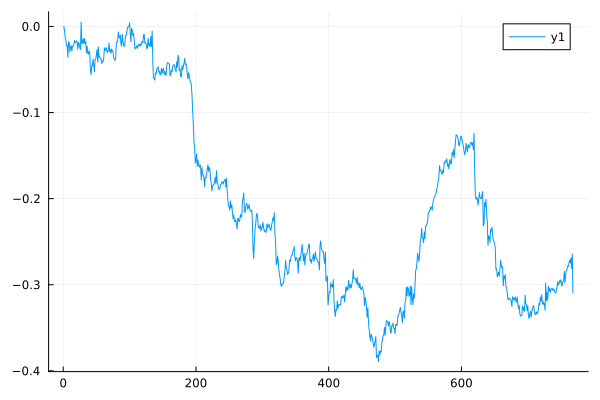

In [75]:
X = Float32.(npzread("/home/eric/src/bptt-julia/example_data/RAM_PLRNN_data_C_009_X28.npy"))
plot(X[:, 1])

In [102]:
noisest(X[:,1])

0.004202639718600076

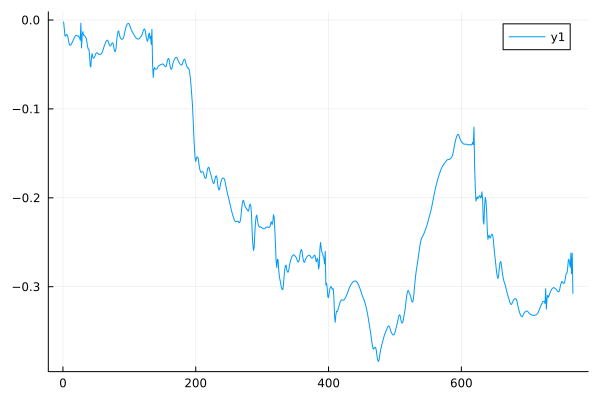

In [76]:
plot(denoise(X[:,1]))

0:160

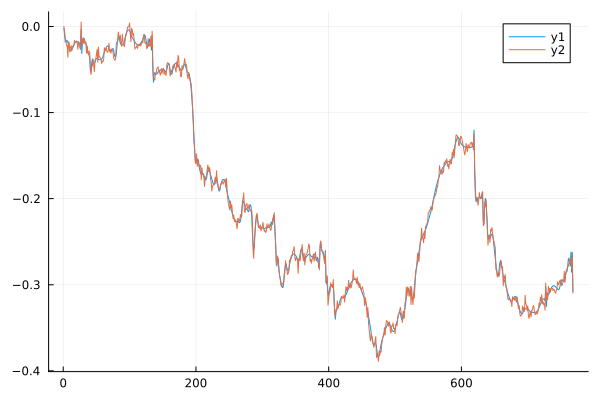

In [79]:
t = range(0, stop=10, length=1000) # observation times
x = sin.(2t) .* cos.(5t) - 1.5cos.(6t) .* sin.(2t) + 0.2.*sin.(20t) # the original signal

x = X[:, 1]

hrf = spm_hrf(0.2)
x_conv = X[:, 1]#[1:end-160]
n = randn(length(x_conv)) .* noisest(x_conv) # noise to be added
signal = x_conv

signal_dn = denoise(signal)

ir = [hrf; Zeros(size(signal, 1) - size(hrf,1))]
x_deconv = wiener(signal, signal_dn, n, ir) 

plot(signal_dn)
plot!(x_conv)

In [94]:
function Wiener_Deconvolution(batch::AbstractArray{T, 3}, hrf::AbstractVector, σ::Real) where {T}
    ir = [hrf; Zeros(size(batch, 3) - size(hrf,1))]
    batch_deconv = zeros(size(batch))

    for i in 1:size(batch,1)
        for j in 1:size(batch,2)
            noise = randn(size(ir,1)) .* σ

            batch_deconv[i,j,:] = wiener(batch[i,j,:]+noise, batch[i,j,:], noise, ir)
        end
    end
    return batch_deconv
end

Wiener_Deconvolution (generic function with 6 methods)

In [90]:
Wiener_Deconvolution(ones(16,3,300), hrf)

16×3×300 Array{Float64, 3}:
[:, :, 1] =
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN

[:, :, 2] =
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN

[:, :, 3] =
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN

;;; … 

[:, :, 298] =
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  NaN
 NaN  NaN  

In [96]:
d = Normal(0., 0.1)
rng = MersenneTwister(0)

MersenneTwister(0)

0:160

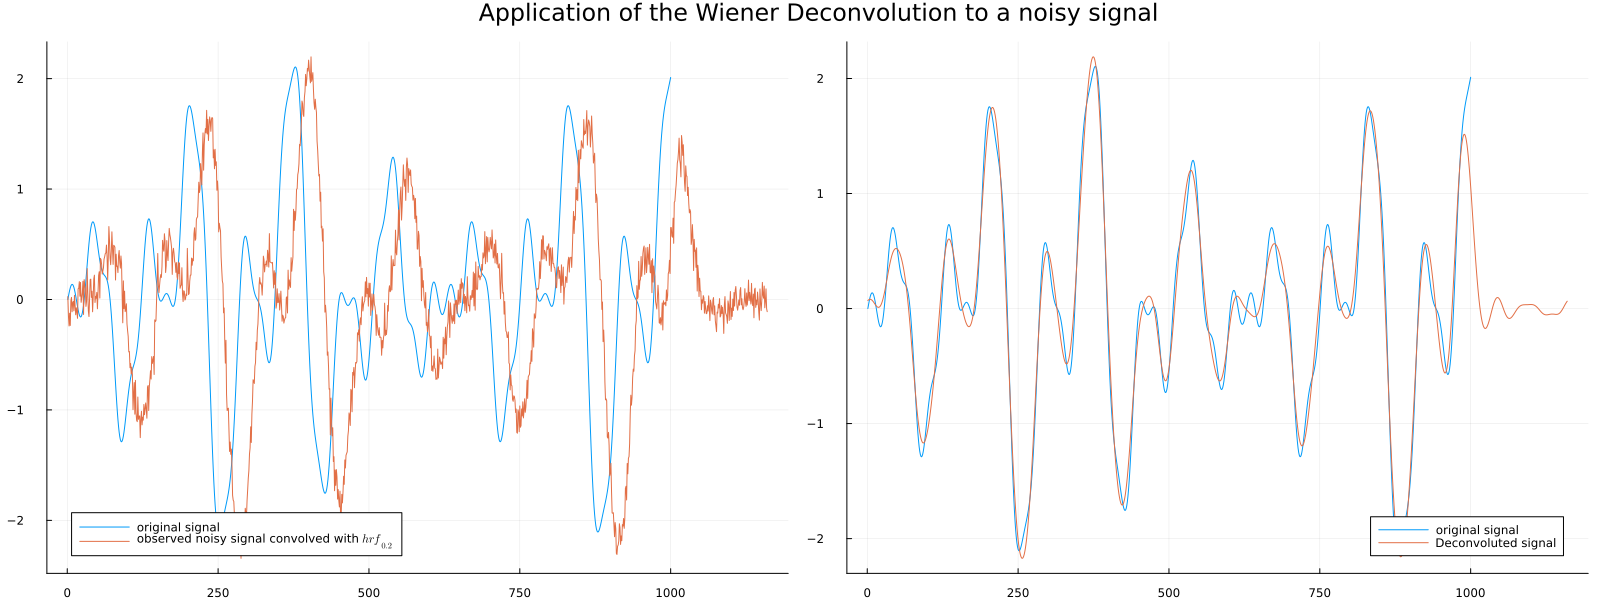

In [101]:
t = range(0, stop=10, length=1000) # observation times
x = sin.(2t) .* cos.(5t) - 1.5cos.(6t) .* sin.(2t) + 0.2.*sin.(20t) # the original signal
y = sinpi.(t)# .* cos.(7t.+1) - cospi.(2t) .* sin.(4t)
z = cospi.(t)# .* cos.(3t.+1) - cospi.(4t.+1) .* sin.(3t)

#using NPZ
#X = Float32.(npzread("/home/eric/src/bptt-julia/example_data/lorenz.npy"));
#x = X[501:1500, 1]

hrf = spm_hrf(0.2)

x_conv = DSP.conv(x, hrf)#[1:end-160]
#y_conv = DSP.conv(y, spm_hrf(0.2))[160:end-160]
#z_conv = DSP.conv(z, spm_hrf(0.2))[160:end-160]



n = rand(rng, d, length(x_conv)) # noise to be added
x_n = x_conv + n # observed noisy signal
#y_n = y + 3(n .- mean(n))
#z_n = z + 3(n .- mean(n))

signal = x_n
#n = randn(size(signal,1)) .* 0.1
ir = [hrf; Zeros(size(signal, 1) - size(hrf,1))]
x_deconv = wiener(signal, signal, n, ir) 


p1 = plot(x, label="original signal ")
p1 = plot!(x_n, label="observed noisy signal convolved with \$hrf_{0.2}\$")

p2 = plot(x, label="original signal")
p2 = plot!(x_deconv, label="Deconvoluted signal")

plot(p1, p2, layout=(1,2), size=(1600,600))
plot!(plot_title="Application of the Wiener Deconvolution to a noisy signal", titlefontsize=16)
#plot!(y_n[2:1000], label="observed noisy signal")
#plot!(z_n[2:1000], label="observed noisy signal")
#savefig("/home/eric/src/master_code/notebooks/Wiener_Deconv_results/wiener_deconv.png") 

In [81]:
False

LoadError: UndefVarError: False not defined

In [9]:
using LinearAlgebra
function getConvolutionMatrix(impulse_response::AbstractVector, signal_len::Int)
    m = size(impulse_response)[1]
    n = signal_len
    matrix = zeros((n, n+m-1))
    for i in 1:n
        matrix[i, i:(m+i-1)] = impulse_response
    end
    return transpose(matrix)
end

function getDeconvolutionMatrix(impulse_response::AbstractVector, signal_len::Int)
    conv_mat = getConvolutionMatrix(impulse_response, signal_len-size(impulse_response,1)+1)
    deconv_mat = pinv(conv_mat)
    return deconv_mat
end

getDeconvolutionMatrix (generic function with 1 method)

In [4]:
using FillArrays
function Wiener_Deconvolution(batch_conv, batch, hrf, σ=2)
    ir = [hrf; Zeros(size(batch_conv, 1) - size(hrf,1))]
    noise = randn(size(ir,1))/σ
    
    batch_deconv = zeros(size(batch))
    for i in 1:size(batch,3)
        for j in 1:size(batch,2)
            batch_deconv[:,j,i] = wiener(batch_conv[:,j,i]+noise, batch_conv[:,j,i], noise, ir)
        end
    end
    return batch_deconv
end

Wiener_Deconvolution (generic function with 2 methods)

0:160

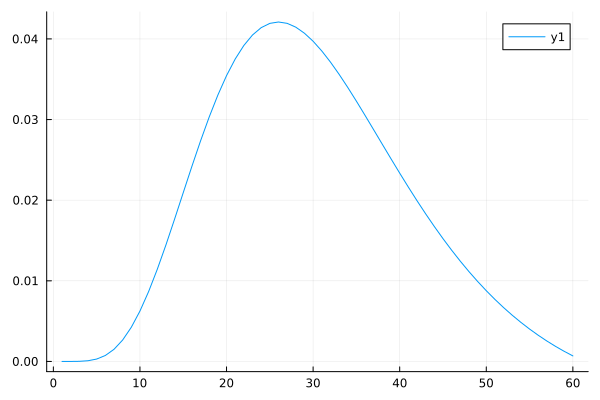

In [12]:
plot(spm_hrf(0.2)[1:60])

In [18]:
hrf = spm_hrf(0.2)[1:60]
pad = size(hrf,1)

x_conv = DSP.conv(x, hrf)[pad:end-pad]

signal = x_conv[1001:2000]
n = randn(size(signal,1)) .* 0.1
ir = [hrf; Zeros(size(signal, 1) - size(hrf,1))]
x_deconv = wiener(signal+n, signal, n, ir) 

x_reconv = DSP.conv(x_deconv, hrf)

0:160

1059-element Vector{Float64}:
  2.220446049250313e-16
 -2.928151900949416e-7
 -7.949451455990797e-6
 -5.523952770525309e-5
 -0.0002169693487726887
 -0.0006169856199029627
 -0.001422813699659839
 -0.0028313905464702194
 -0.005049980133679549
 -0.008276050774439936
 -0.012678989907365656
 -0.018385498207138085
 -0.025469574590935906
  ⋮
 -0.03977738608820283
 -0.03250535642633898
 -0.026151115809715172
 -0.02065546595987862
 -0.01595769131331398
 -0.011996511186113543
 -0.008710973132846328
 -0.006041287913015579
 -0.003929558059393483
 -0.002320386860627966
 -0.0011613198439001959
 -0.0004031408388079504

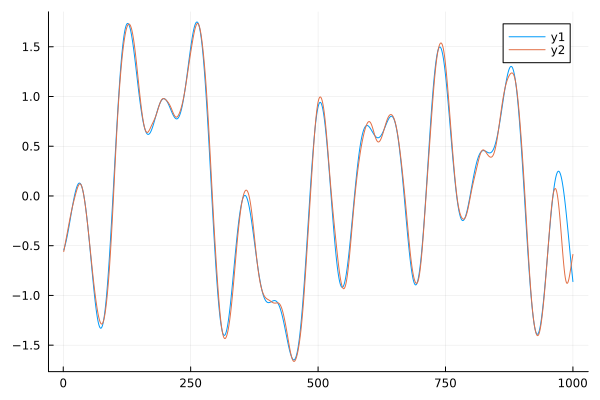

In [20]:
plot(x[1001+pad:2000+pad])
#plot(signal)
#plot!(x_conv[1000:2000])
plot!(x_deconv)

In [6]:
plot(x_reconv)
plot!(x_conv[1001:2000])

LoadError: UndefVarError: x_reconv not defined

In [85]:
BPTT.ObservationModels.HRF_Identity

LoadError: UndefVarError: HRF_Identity not defined

0:160

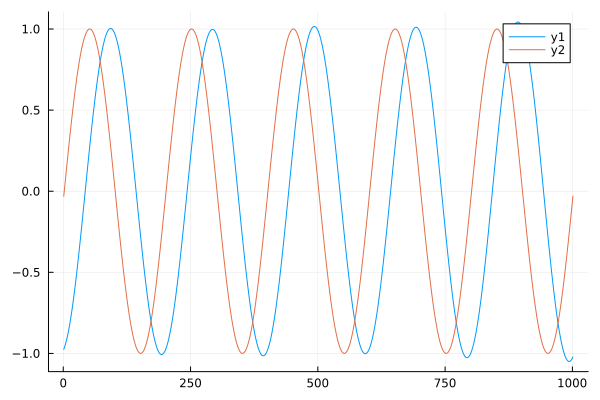

In [78]:

batch_conv = hcat(x_conv, y_conv, z_conv)[:,:,:]

batch_deconv = Wiener_Deconvolution(batch_conv, batch_conv, spm_hrf(0.2))

plot(batch_deconv[1000:2000,1,1])
plot!(x[1000:2000])

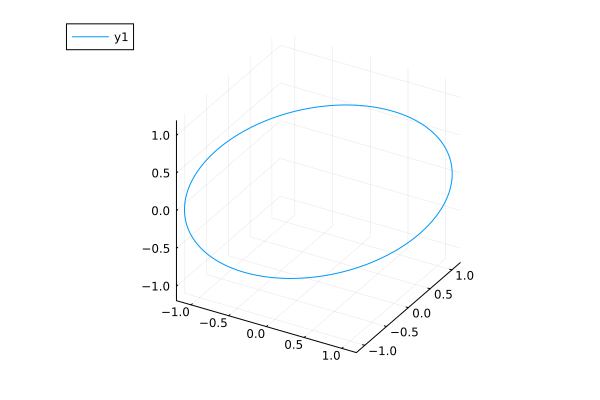

In [68]:
#y = ones(size(x,1))
#z = zeros(size(x,1))

plot(x_conv,y_conv,z_conv)

In [52]:
size(hcat(x,y,z))
npzwrite("/home/eric/src/bptt-julia-mri/example_data/sin_data.npy", hcat(x,y,z))

In [44]:
X = Float32.(npzread("/home/eric/src/bptt-julia-mri/example_data/sin_data.npy"));
size(X)

(100000, 3)

In [23]:
@load "/home/eric/src/bptt-julia/Results/default/test/199/obs_model_checkpoint/O_5000.bson" model

O_lin = model;

@load "/home/eric/src/bptt-julia/Results/default/test/199/checkpoints/model_5000.bson" model

model_lin = model;

LoadError: UndefVarError: LinearObservation not defined

In [45]:
using NPZ
X = Float32.(npzread("/home/eric/src/bptt-julia/example_data/lorenz_hrf.npy"));
size(X)

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


(100026, 3)

In [14]:
using FillArrays
hrf_signal = spm_hrf(1.2)
size([hrf_signal;Zeros(100)])

0:26

(127,)

0:160

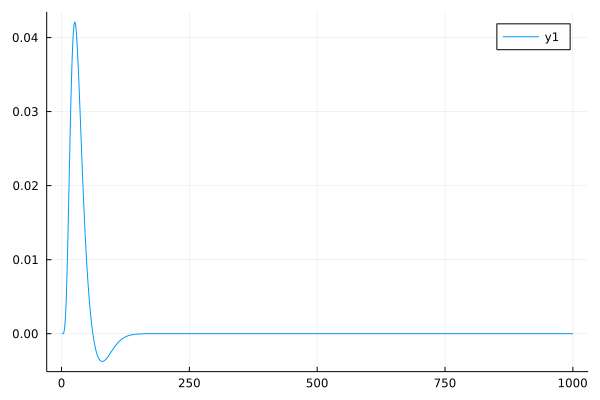

In [15]:
# Gaussian blurring kernel
kernel = exp.( - 10 .* (t .- 5).^2)
kernel ./= sum(kernel) # normalize kernel to sum of 1
kernel = ifftshift(kernel) # move center to index pos 1

#hrf kernel
hrf_signal = spm_hrf(0.2)
ir = [hrf_signal;Zeros(size(x,1) - size(hrf_signal,1))]

plot(ir)

In [16]:
size(x)

(1000,)

In [19]:
noise = randn(size(x, 1))/10

y_blurred = real(ifft(fft(ir) .* fft(x))) + noise
y_blurred = DSP.conv(x, ir) #+ randn(1999)

deblurred = wiener(y_blurred, x, noise, ir)

plot(t, x, size=(900, 600), label="Original signal", linewidth=2)
plot!(t, y_blurred, label="Blurred signal")
plot!(t, deblurred, label="Deblurred with Wiener")

LoadError: AssertionError: size(input) == size(signal) == size(noise) == size(blurring)

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

KeyError: KeyError: key "debug_request" not found

In [7]:
import Pkg; Pkg.add("FillArrays")

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
